
# **Slot Machine**<br>
If you are using BigQuery with the on demand billing model where you are billed by bytes scanned, it may be a good idea to switch to the Editions model where you are billed for slots you used.

There are Two quite complicated querstions though:


1.   Will moving to Editions save me money ?
2.   How many slots should I reserve, what is the optimal max_xlots value ?

There is no way to be 100% accurate in advance, but this set of queries aims to reduce the guesswork and guide you in finding better answers to the Two questions above.





**Usage**<br>
You should run this in the project you want to test.

**Step 1**<br>
First we set some parameters such as region, timeframe and BigQuery edition. We also detect the current project id.

In [ ]:
import google.auth
project_id = google.auth.default()[1]
region = "US" # @param {"type":"string", "placeholder": "Enter dataset region"}
dataset = "test" # @param {"type":"string", "placeholder": "Enter the target dataset where objects will be created"}
start_timestamp = "2024-09-08" # @param {"type":"date"}
end_timestamp = "2024-09-10" # @param {"type":"date"}
edition = "Enterprise" # @param ["Standard", "Enterprise", "Enterprise plus"]
debug = False # @param {"type":"boolean"}

**Step 2**<br>
Here we import some python packages and create the dataset if it does not already exist.

In [ ]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

client = bigquery.Client()
my_dataset = bigquery.Dataset(project_id+"."+dataset)
my_dataset.location = region


try:
    client.get_dataset(project_id+"."+dataset)
    print("Dataset {} already exists".format(dataset))
except NotFound:
    print("Dataset {} is not found".format(dataset), "creating it.")
    dataset = client.create_dataset(my_dataset, timeout=30)

Dataset test already exists


**Step 3**<br>
Ceate a table with the on demand consumption for reference. The table name is bytes.<br>
We select from INFORMATION_SCHEMA.JOBS to find the total bytes billed during the timeframe and what was the cost in USD.<br>Write down the result.

In [ ]:
query = "create or replace table "+dataset+".bytes as "+"""SELECT
  SUM(total_bytes_billed/1024/1024/1024/1024) AS total_tb_billed,
  SUM(total_bytes_billed/1024/1024/1024/1024)*6.25 as cost_usd
FROM """+project_id+".region-"+region+""".INFORMATION_SCHEMA.JOBS
WHERE
  creation_time BETWEEN CAST(\""""+start_timestamp+"""\" AS TIMESTAMP)
  AND """+"CAST(\""+end_timestamp+"\" AS TIMESTAMP)"

if debug then:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

**Step 4**<br>
Then we query INFORMATION_SCHEMA.JOBS_TIMELINE on the same time range to see how many slots were used in every second of the time range. We send the result to a table called slots.

In [ ]:
query = "create or replace table "+dataset+".slots as "+"""SELECT
  period_start,
  SUM(period_slot_ms/1000) AS total_slot_ms,
FROM
  """+project_id+".region-"+region+""".INFORMATION_SCHEMA.JOBS_TIMELINE
WHERE
  period_start BETWEEN CAST(\""""+start_timestamp+"""\" AS TIMESTAMP)
  AND """+"CAST(\""+end_timestamp+"\" AS TIMESTAMP)"""

query = query + """
GROUP BY
  period_start
ORDER BY
  period_start DESC"""

if debug then:
  print(query)
df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

create or replace table test.slots as SELECT
  period_start,
  SUM(period_slot_ms/1000) AS total_slot_ms,
FROM
  nexite-434614.region-US.INFORMATION_SCHEMA.JOBS_TIMELINE
WHERE
  period_start BETWEEN CAST("2024-09-08" AS TIMESTAMP)
  AND CAST("2024-09-10" AS TIMESTAMP)
GROUP BY
  period_start
ORDER BY
  period_start DESC


**Step 5**<br>
We create a dynamic query that creates buckets incremented by 50 from 0 to the highest number of slots used during the selected time period.<br>
The original time periods are seconds, so we aggregate the data in Minute granularity and for each minute we take the high<br> watermark of slot usage (since BigQuery autoscaler's minimum is 1 minute).<br><br>
Then we assign each minute to a specific bucket according to the maximum slots that ut used.<br>
We create a view called bucketed to hold the result and enable further calculations.

In [ ]:
query1 = "select max(total_slot_ms) as max_slots from "+dataset+".slots"
df = pd.io.gbq.read_gbq(query=query1, project_id=project_id, dialect='standard')
max_slots = int(df._get_value(0, 'max_slots'))
query2 = "create or replace view "+dataset+".bucketed"+""" as SELECT
  timestamp_trunc(period_start, MINUTE) as period_start,
  max(case
when total_slot_ms = 0 then 0\n"""
for i in range(0, max_slots, 50):
  line = "when total_slot_ms between "+str(i)+" and "+str(i+50)+" then "+str(i+50)+'\n'
  query2 = query2 + line
query2 = query2 + """  end) as bucket
FROM """+dataset+""".slots
  group by timestamp_trunc(period_start, MINUTE)"""

if debug then:
  print(query2)

df = pd.io.gbq.read_gbq(query=query2, project_id=project_id, dialect='standard')

**Step 6**<br>
Here we create a view called buckets_count that shows hoe many time periods (minutes) fall into each bucket.<br>
Then we print the contents of the view.

In [ ]:
query = "create or replace view "+dataset+""".buckets_count as SELECT
  bucket,
  COUNT(*) as periods,
FROM `"""+project_id+"."+dataset+""".bucketed`
where bucket is not null
GROUP BY
  bucket"""

if debug then:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
query = 'select * from '+dataset+".buckets_count order by bucket"

if debug then:
  print(query)
df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
print(df)

     bucket  periods
0         0       62
1        50     1626
2       100      316
3       150      168
4       200       92
..      ...      ...
179   14550        1
180   14700        1
181   16800        1
182   20400        1
183   21250        1

[184 rows x 2 columns]


For our next calculations we need to know Two numbers:


1.   How many hours there are in our timeframe
2.   How many time periods we have

So steps 7 and 8 find those values.





**Step 7**<br>
Calculate how many hours we have in the chosen time frame.

In [ ]:
from datetime import datetime
date_format = '%Y-%m-%d'
diff = datetime.strptime(end_timestamp,date_format) - datetime.strptime(start_timestamp, date_format)
hours = diff.days * 24 + diff.seconds / 3600

**Step 8**<br>
Calculate how many time slots we have.

In [ ]:
query = "select count(*) as periods from "+dataset+".buckets"
df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
periods = df._get_value(0, 'periods')

**Step 9**<br>
This is the heart of our calculation.<br><br>
We know how many hours were in the selected timeframe and how many time periods we had during this timeframe.
So we can calculate what is the percentage of all the time that we used each bucket.<br>
If we know the percentage of time and we know how many wours we had in the timeframe then we can calculate how many hours each bucket was active.<br>
And we know how much each slot/hour costs for each BigQuery edition so we can calculate the cost each bucket incured.

So here we create a view called calculated that holds the bucket, the percentage of all time that this bucket was used, how many hours it was used, and how much we would be charged for it if we use the selected edition.

In [ ]:
if edition == 'Enterprise':
  price = 0.6
elif edition == 'Enterprise plus':
  price = 0.1
else:
  peice = 0.4

query = "create or replace view "+dataset+""".calculated as SELECT
  bucket,
  round(periods/"""+str(periods)+"""*100, 3) as percentage,
  round(periods/"""+str(periods)+"*100/100*"+str(hours)+""", 3) as hours,
  round(periods/"""+str(periods)+"*100/100*"+str(hours)+"*bucket*"+str(price)+""", 3) as cost_usd
FROM
  `"""+project_id+"."+dataset+""".buckets_percentage`
  order by bucket"""

if debug then:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')

**Let's see how it looks like.**

In [ ]:
%%bigquery calculated
select * from test.calculated;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(calculated)

    bucket  percentage   hours  cost_usd
0        0       1.351   0.649     0.000
1       50      35.440  17.011   510.340
2      100       6.888   3.306   198.361
3      150       3.662   1.758   158.187
4      200       2.005   0.963   115.501
..     ...         ...     ...       ...
90    4500       0.741   0.356   960.418
91    4550       0.806   0.387  1056.774
92    4600       0.501   0.241   664.133
93    4650       0.588   0.282   788.108
94    4700       0.545   0.262   737.576

[95 rows x 4 columns]


**Stage 10**<br>
Here is a visualization of the histogram that shows the distribution of the slot buckets and the time spent in each of them.<br>
There should be a "sweet spot" where most of the buckets under it are heavily used and above it there is only slight usage.<br>
This shhould give you the sense of where that sweet spot should be.

<Axes: xlabel='bucket'>

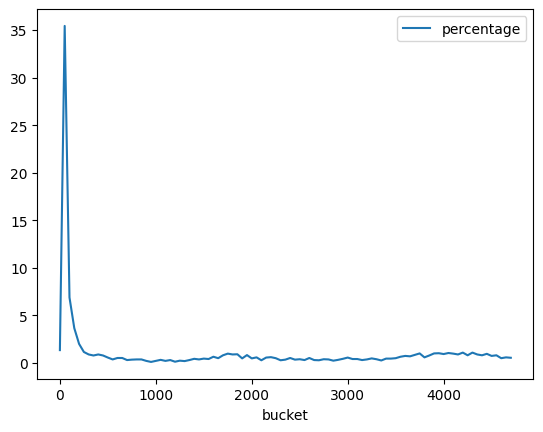

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

calculated.plot(x="bucket", y="percentage", kind="line")

**Step 11**<br>
Use the following query to identify where slot usage drops below 1% of the time.

In [ ]:
query = "select min(bucket) as recommended from "+dataset+".calculated where percentage < 1"

if debug then:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
print(df)

   recommended
0          300


**Step 12**<br>
The following steps try to find the optimal max_slots that best balances cost and performance.<br>
As a first step choose the max_slots value you want to check.

In [ ]:
max_slots = 600 # @param {"type":"number"}

**Explanation**<br>
The trade off is cost vs. performance. If we choose the right max_slots than we can reduce the cost while only a small number of queries will decrease in performance. If these are not time critical queries (such as ETLs, background jobs etc.) than we may want to "sacrifice" them in return for  lower cost.

**Step 13**<br>
We try to calculate how much will we pay if we choose the above max_slots.<br>
This is a naive approach as it does not take into consideration all the buckers above the max_slots, as they all had 0 percent.

In [ ]:
answer = calculated[calculated['bucket'] <= max_slots]
summed = answer['cost_usd'].sum()
print('Naive total cost estimation for the time frame using maximum slots '+str(max_slots)+' is '+str(summed)+' USD.' )

Naive total cost estimation for the time frame using maximum slots 600 is 1657.191 USD.


**Step 14**<br>
Hpwever, in the real world, all those buckets that are above max_slots will be accumulated and treated as max_slots.<br>
For example, if we choose 700 as our max_slots and we have 2 percent in 700 and 1 percent in 900 slots and 1 percent at 1000 slots, then all percentage above 700 slots will consolidate at 700 slots and we will end up with 4 percent at 700 slots.<br><br>
This strp calculate this scenario.

In [ ]:
till_max = calculated[calculated['bucket'] <= max_slots]
above_max = calculated[calculated['bucket'] > max_slots]
intermediate = above_max['hours'].sum()*price*max_slots
summed = answer['cost_usd'].sum() + intermediate
print('Real total cost estimation for the time frame using maximum slots '+str(max_slots)+' is '+str(summed)+' USD.' )

Real total cost estimation for the time frame using maximum slots 600 is 9377.751 USD.


**Step 15**<br>
Finally, we want to see which queries will take a performance hit (the ones that has slot consumption above max_slots).

In [ ]:
query = """SELECT
  *
FROM (
  SELECT
    timeline.job_id AS job_id,
    jobs.query AS query,
    jobs.job_type AS job_type,
    ROUND(SUM(timeline.period_slot_ms/1000)) AS total_slot_ms,
    COUNT(timeline.job_id) AS slices
  FROM
    `"""+project_id+"`.`region-"+region+"""`.INFORMATION_SCHEMA.JOBS_TIMELINE AS timeline
  JOIN
    `"""+project_id+"`.`region-"+region+"""`.INFORMATION_SCHEMA.JOBS AS jobs
  ON
    timeline.job_id = jobs.job_id
  WHERE
    period_start BETWEEN CAST(\""""+start_timestamp+"""\" AS TIMESTAMP)
  AND """+"CAST(\""+end_timestamp+"\" AS TIMESTAMP)"""+"""
  GROUP BY
    job_id,
    query,
    job_type
  ORDER BY
    slices DESC)
WHERE
  total_slot_ms>"""+str(max_slots)

if debug then:
  print(query)

df = pd.io.gbq.read_gbq(query=query, project_id=project_id, dialect='standard')
print(df)


Empty DataFrame
Columns: [job_id, query, job_type, total_slot_ms, slices]
Index: []
